In [2]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [62]:
##Inspecting the data of the Jena weather dataset
import os
data_dir = '/content'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

with open(fname) as f: data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [68]:
import numpy as np

# Skip the header row and load data directly into NumPy arrays
data = np.array([line.split(",")[1:] for line in lines[1:]], dtype=np.float32)

# Extract temperature values
temperature = data[:, 1]  # Assuming temperature is the second column, change the index if it's different

# Extract raw_data, excluding the Date Time and Temperature columns
raw_data = data[:, 2:]  # Adjust the columns if needed

# Now temperature and raw_data arrays are populated correctly


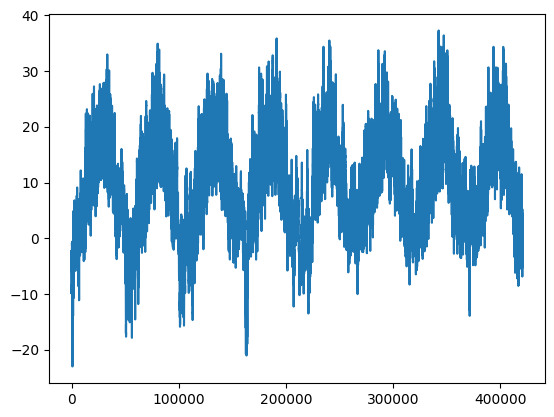

In [69]:
import matplotlib.pyplot as plt

###Plotting the temperature timeseries
plt.plot(range(len(temperature)), temperature)

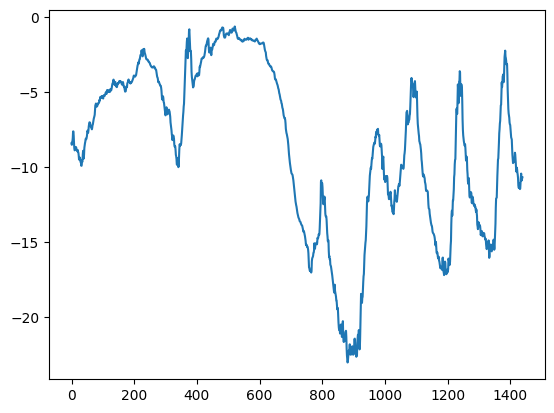

In [70]:
##Plotting the first 10 days of the temperature timeseries
plt.plot(range(1440), temperature[:1440])

In [71]:
""" Computing the number of samples we'll use for each data split """
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105113


Preparing the data

In [72]:
#Normalizing the data
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [73]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


Instantiating datasets for training, validation, and testing

In [74]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

# Common dataset creation parameters
common_params = {
    "sampling_rate": sampling_rate,
    "sequence_length": sequence_length,
    "shuffle": True,
    "batch_size": batch_size,
}

# Create train, validation, and test datasets
train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    start_index=0,
    end_index=num_train_samples,
    **common_params
)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples,
    **common_params
)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    start_index=num_train_samples + num_val_samples,
    **common_params
)


In [75]:
for samples, targets in train_dataset.take(1):
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)


samples shape: (256, 120, 12)
targets shape: (256,)


#Model 1 - Model with non-machine-learning baseline

In [76]:
def calculate_mae(dataset, std, mean):
    total_absolute_error = 0
    total_samples = 0

    for samples, targets in dataset:
        predicted_values = samples[:, -1, 1] * std[1] + mean[1]
        total_absolute_error += np.sum(np.abs(predicted_values - targets))
        total_samples += samples.shape[0]

    mae = total_absolute_error / total_samples  # Use floating-point division to get the MAE

    return mae

validation_mae = calculate_mae(val_dataset, std, mean)
test_mae = calculate_mae(test_dataset, std, mean)

print(f"Validation MAE: {validation_mae:.2f}")
print(f"Test MAE: {test_mae:.2f}")


Validation MAE: 4.73
Test MAE: 5.24


#Model 2 - Basic machine-learning model

In [77]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 11s 13ms/step - loss: 16.4957 - mae: 3.1200 - val_loss: 11.1096 - val_mae: 2.5996
Epoch 2/10
819/819 [==============================] - 11s 13ms/step - loss: 10.6828 - mae: 2.5654 - val_loss: 11.4584 - val_mae: 2.6310
Epoch 3/10
819/819 [==============================] - 11s 13ms/step - loss: 9.7617 - mae: 2.4535 - val_loss: 10.1792 - val_mae: 2.4869
Epoch 4/10
819/819 [==============================] - 10s 13ms/step - loss: 9.2071 - mae: 2.3863 - val_loss: 10.4937 - val_mae: 2.5323
Epoch 5/10
819/819 [==============================] - 10s 13ms/step - loss: 8.7796 - mae: 2.3310 - val_loss: 10.5391 - val_mae: 2.5474
Epoch 6/10
819/819 [==============================] - 10s 13ms/step - loss: 8.4407 - mae: 2.2892 - val_loss: 10.6378 - val_mae: 2.5625
Epoch 7/10
819/819 [==============================] - 11s 13ms/step - loss: 8.2043 - mae: 2.2582 - val_loss: 11.0028 - val_mae: 2.6130
Epoch 8/10
819/819 [==============================] -

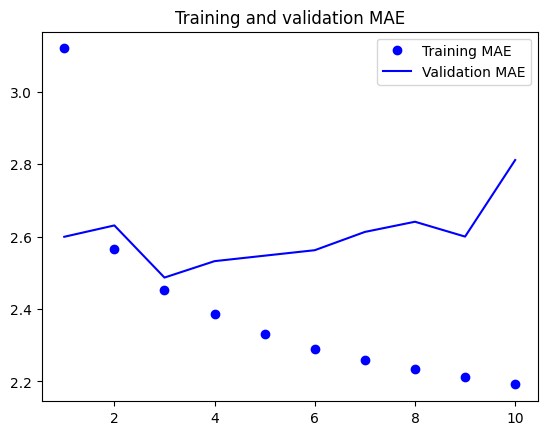

In [78]:
##Plotting results
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

#Model 3 - 1D convolutional model

In [79]:
#Let's try a 1D convolutional model

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 15s 18ms/step - loss: 25.9232 - mae: 3.8915 - val_loss: 18.2414 - val_mae: 3.4446
Epoch 2/10
819/819 [==============================] - 14s 17ms/step - loss: 15.8918 - mae: 3.1713 - val_loss: 17.1261 - val_mae: 3.2917
Epoch 3/10
819/819 [==============================] - 14s 17ms/step - loss: 14.5499 - mae: 3.0345 - val_loss: 16.1451 - val_mae: 3.1504
Epoch 4/10
819/819 [==============================] - 14s 17ms/step - loss: 13.6571 - mae: 2.9386 - val_loss: 18.4399 - val_mae: 3.3814
Epoch 5/10
819/819 [==============================] - 14s 17ms/step - loss: 13.0582 - mae: 2.8692 - val_loss: 14.9861 - val_mae: 3.0558
Epoch 6/10
819/819 [==============================] - 15s 18ms/step - loss: 12.5554 - mae: 2.8119 - val_loss: 15.1433 - val_mae: 3.0535
Epoch 7/10
819/819 [==============================] - 15s 18ms/step - loss: 12.1386 - mae: 2.7628 - val_loss: 14.3336 - val_mae: 2.9783
Epoch 8/10
819/819 [============================

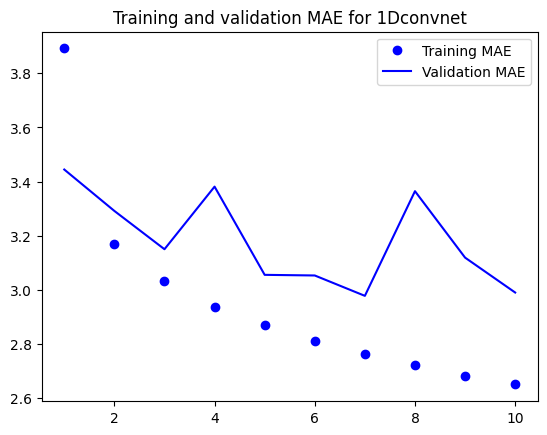

In [80]:
##Plotting results
import matplotlib.pyplot as plt

loss = history.history["mae"]  # Use a space to separate the variable names
val_loss = history.history["val_mae"]  # Use a space to separate the variable names

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE for 1Dconvnet")
plt.legend()
plt.show()


#Model 4 - A simple LSTM-based model with 16 layer

In [81]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define the input shape and create the LSTM model
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# Define callbacks to save the best model during training
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras", save_best_only=True)
]

# Compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# Train the model
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)

# Load the best model from the saved checkpoint
model = keras.models.load_model("jena_lstm.keras")

# Evaluate the model on the test dataset and print the test MAE
test_loss, test_mae = model.evaluate(test_dataset)
print(f"Test MAE: {test_mae:.2f}")


Epoch 1/10
819/819 [==============================] - 59s 69ms/step - loss: 41.8484 - mae: 4.7265 - val_loss: 12.6417 - val_mae: 2.7159
Epoch 2/10
819/819 [==============================] - 54s 66ms/step - loss: 11.3718 - mae: 2.6218 - val_loss: 10.0548 - val_mae: 2.4556
Epoch 3/10
819/819 [==============================] - 54s 66ms/step - loss: 10.1223 - mae: 2.4763 - val_loss: 9.8664 - val_mae: 2.4281
Epoch 4/10
819/819 [==============================] - 53s 64ms/step - loss: 9.6399 - mae: 2.4142 - val_loss: 9.5166 - val_mae: 2.3939
Epoch 5/10
819/819 [==============================] - 54s 65ms/step - loss: 9.2542 - mae: 2.3681 - val_loss: 9.7489 - val_mae: 2.4222
Epoch 6/10
819/819 [==============================] - 52s 64ms/step - loss: 8.8595 - mae: 2.3219 - val_loss: 9.9524 - val_mae: 2.4448
Epoch 7/10
819/819 [==============================] - 53s 65ms/step - loss: 8.5533 - mae: 2.2798 - val_loss: 10.3647 - val_mae: 2.4804
Epoch 8/10
819/819 [==============================] - 54

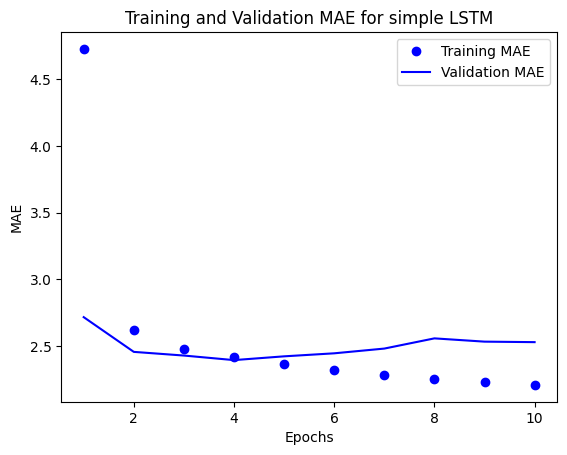

In [82]:
##Plotting results

import matplotlib.pyplot as plt

# Assuming you have 'history' object containing training history
mae = history.history['mae']
val_mae = history.history['val_mae']
epochs = range(1, len(mae) + 1)

plt.figure()
plt.plot(epochs, mae, 'bo', label='Training MAE')
plt.plot(epochs, val_mae, 'b', label='Validation MAE')
plt.title('Training and Validation MAE for simple LSTM')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()


#Model 5 - A simple GRU-based model - Adjusting Units in Recurrent Layers

In [84]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define the model
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# Define callbacks to save the best model
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_gru.keras", save_best_only=True)
]

# Compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# Train the model
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)

# Load the best model and evaluate it on the test dataset
model = keras.models.load_model("jena_gru.keras")
test_loss, test_mae = model.evaluate(test_dataset)
print(f"Test MAE: {test_mae:.2f}")


Epoch 1/10
819/819 [==============================] - 51s 60ms/step - loss: 44.4396 - mae: 4.8657 - val_loss: 13.6208 - val_mae: 2.7716
Epoch 2/10
819/819 [==============================] - 48s 58ms/step - loss: 11.0572 - mae: 2.5857 - val_loss: 9.3069 - val_mae: 2.3654
Epoch 3/10
819/819 [==============================] - 47s 58ms/step - loss: 9.8423 - mae: 2.4521 - val_loss: 9.5124 - val_mae: 2.3972
Epoch 4/10
819/819 [==============================] - 48s 59ms/step - loss: 9.5212 - mae: 2.4116 - val_loss: 9.4725 - val_mae: 2.3879
Epoch 5/10
819/819 [==============================] - 48s 58ms/step - loss: 9.2451 - mae: 2.3777 - val_loss: 9.6312 - val_mae: 2.4022
Epoch 6/10
819/819 [==============================] - 49s 59ms/step - loss: 8.9980 - mae: 2.3485 - val_loss: 9.8270 - val_mae: 2.4198
Epoch 7/10
819/819 [==============================] - 48s 59ms/step - loss: 8.8058 - mae: 2.3272 - val_loss: 9.4536 - val_mae: 2.3842
Epoch 8/10
819/819 [==============================] - 48s 5

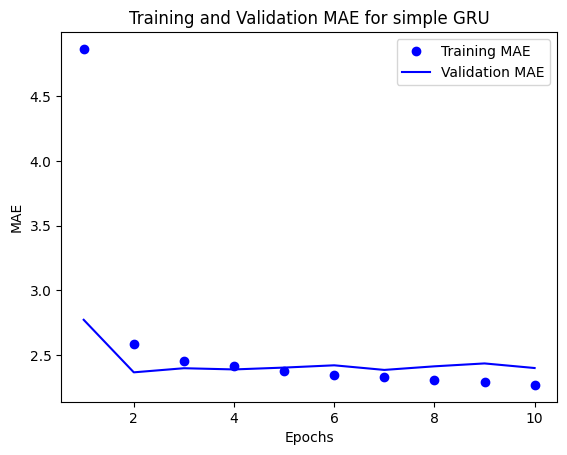

In [85]:
##Plotting results

import matplotlib.pyplot as plt

# Assuming you have 'history' object containing training history
mae = history.history['mae']
val_mae = history.history['val_mae']
epochs = range(1, len(mae) + 1)

plt.figure()
plt.plot(epochs, mae, 'bo', label='Training MAE')
plt.plot(epochs, val_mae, 'b', label='Validation MAE')
plt.title('Training and Validation MAE for simple GRU')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()


#Model 6 - Training and evaluating a dropout-regularized LSTM - Swapping LSTM for GRU

In [89]:
# Define the model with dropout layers
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# Define callbacks to save the best model
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras", save_best_only=True)
]

# Compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# Train the model for 30 epochs
history = model.fit(train_dataset, epochs=30, validation_data=val_dataset, callbacks=callbacks)


Epoch 1/30
819/819 [==============================] - 84s 99ms/step - loss: 29.1794 - mae: 3.9839 - val_loss: 10.1777 - val_mae: 2.4829
Epoch 2/30
819/819 [==============================] - 81s 99ms/step - loss: 15.1723 - mae: 3.0151 - val_loss: 9.8407 - val_mae: 2.4465
Epoch 3/30
819/819 [==============================] - 81s 98ms/step - loss: 14.2124 - mae: 2.9179 - val_loss: 10.5608 - val_mae: 2.5336
Epoch 4/30
819/819 [==============================] - 82s 100ms/step - loss: 13.5455 - mae: 2.8485 - val_loss: 10.5981 - val_mae: 2.5381
Epoch 5/30
819/819 [==============================] - 82s 100ms/step - loss: 12.9516 - mae: 2.7864 - val_loss: 9.7475 - val_mae: 2.4280
Epoch 6/30
819/819 [==============================] - 82s 99ms/step - loss: 12.5856 - mae: 2.7459 - val_loss: 9.7081 - val_mae: 2.4269
Epoch 7/30
819/819 [==============================] - 81s 99ms/step - loss: 12.1489 - mae: 2.7027 - val_loss: 9.7741 - val_mae: 2.4335
Epoch 8/30
819/819 [==============================

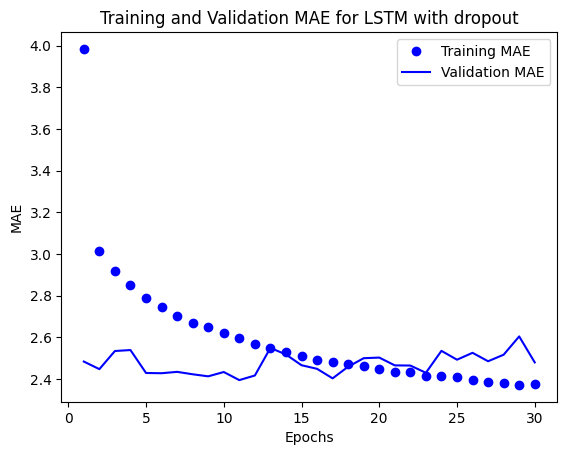

In [90]:
#Plotting results

import matplotlib.pyplot as plt

# Assuming you have 'history' object containing training history
mae = history.history['mae']
val_mae = history.history['val_mae']
epochs = range(1, len(mae) + 1)

plt.figure()
plt.plot(epochs, mae, 'bo', label='Training MAE')
plt.plot(epochs, val_mae, 'b', label='Validation MAE')
plt.title('Training and Validation MAE for LSTM with dropout')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()


#Model 7 - Training and evaluating a dropout-regularized GRU

In [92]:
# Define the model with dropout layers for GRU
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# Define callbacks to save the best model
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_gru_dropout.keras", save_best_only=True)
]

# Compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# Train the model for 30 epochs
history = model.fit(train_dataset, epochs=30, validation_data=val_dataset, callbacks=callbacks)


Epoch 1/30
819/819 [==============================] - 82s 96ms/step - loss: 30.1462 - mae: 4.0285 - val_loss: 10.0877 - val_mae: 2.4626
Epoch 2/30
819/819 [==============================] - 78s 95ms/step - loss: 14.8120 - mae: 2.9941 - val_loss: 9.5846 - val_mae: 2.4111
Epoch 3/30
819/819 [==============================] - 77s 94ms/step - loss: 14.0593 - mae: 2.9144 - val_loss: 9.2616 - val_mae: 2.3744
Epoch 4/30
819/819 [==============================] - 77s 94ms/step - loss: 13.5847 - mae: 2.8584 - val_loss: 9.3843 - val_mae: 2.3860
Epoch 5/30
819/819 [==============================] - 78s 95ms/step - loss: 13.1147 - mae: 2.8131 - val_loss: 9.3505 - val_mae: 2.3774
Epoch 6/30
819/819 [==============================] - 77s 94ms/step - loss: 12.8835 - mae: 2.7845 - val_loss: 9.4563 - val_mae: 2.3920
Epoch 7/30
819/819 [==============================] - 78s 96ms/step - loss: 12.5031 - mae: 2.7488 - val_loss: 9.3811 - val_mae: 2.4050
Epoch 8/30
819/819 [==============================] - 

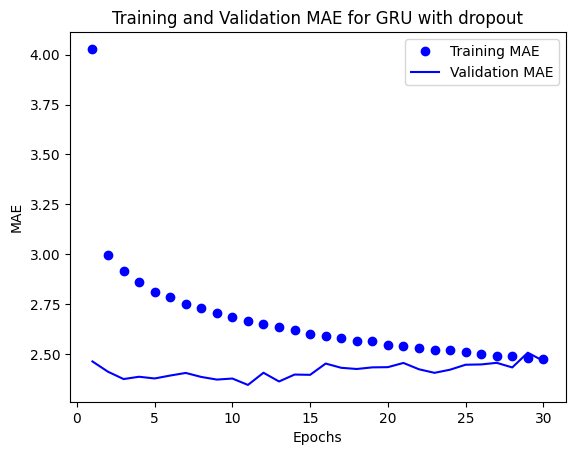

In [93]:
##Plotting results

import matplotlib.pyplot as plt

# Assuming you have 'history' object containing training history
mae = history.history['mae']
val_mae = history.history['val_mae']
epochs = range(1, len(mae) + 1)

plt.figure()
plt.plot(epochs, mae, 'bo', label='Training MAE')
plt.plot(epochs, val_mae, 'b', label='Validation MAE')
plt.title('Training and Validation MAE for GRU with dropout')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

#Model 8 - Training and evaluating a dropout-regularized, stacked GRU model

In [104]:
# Define the stacked GRU model with dropout layers
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(64, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# Define callbacks to save the best model
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras", save_best_only=True)
]

# Compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# Train the model for 10 epochs
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)


Epoch 1/10
819/819 [==============================] - 197s 235ms/step - loss: 17.0920 - mae: 3.1369 - val_loss: 9.3117 - val_mae: 2.3689
Epoch 2/10
819/819 [==============================] - 194s 237ms/step - loss: 12.1134 - mae: 2.7127 - val_loss: 9.3368 - val_mae: 2.3774
Epoch 3/10
819/819 [==============================] - 200s 244ms/step - loss: 11.4564 - mae: 2.6404 - val_loss: 9.0732 - val_mae: 2.3403
Epoch 4/10
819/819 [==============================] - 205s 250ms/step - loss: 10.9766 - mae: 2.5862 - val_loss: 9.2345 - val_mae: 2.3609
Epoch 5/10
819/819 [==============================] - 201s 245ms/step - loss: 10.6161 - mae: 2.5449 - val_loss: 9.3730 - val_mae: 2.3783
Epoch 6/10
819/819 [==============================] - 194s 237ms/step - loss: 10.3003 - mae: 2.5087 - val_loss: 9.5815 - val_mae: 2.3995
Epoch 7/10
819/819 [==============================] - 192s 234ms/step - loss: 9.9619 - mae: 2.4674 - val_loss: 9.3778 - val_mae: 2.3793
Epoch 8/10
819/819 [======================

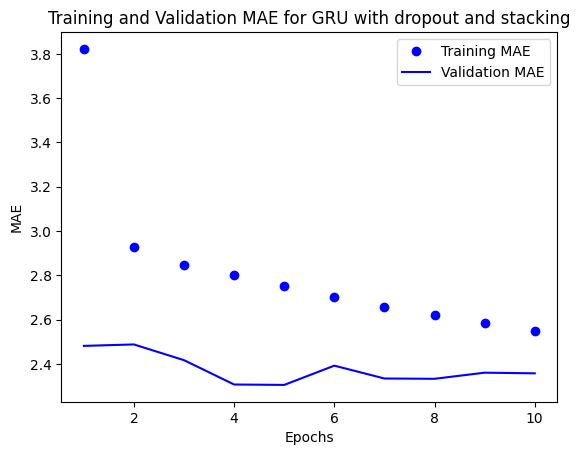

In [98]:
##PLotting result

mae = history.history['mae']
val_mae = history.history['val_mae']
epochs = range(1, len(mae) + 1)

plt.figure()
plt.plot(epochs, mae, 'bo', label='Training MAE')
plt.plot(epochs, val_mae, 'b', label='Validation MAE')
plt.title('Training and Validation MAE for GRU with dropout and stacking')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()


#Model 9 - Building a Conv1D and GRU Model with Dropout


In [99]:

# Define the model
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)

# Add a GRU layer
x = layers.GRU(32, recurrent_dropout=0.25, return_sequences=True)(x)

# Global average pooling
x = layers.GlobalAveragePooling1D()(x)

# Output layer
outputs = layers.Dense(1)(x)

# Create the model
model = keras.Model(inputs, outputs)

# Define callbacks to save the best model
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras", save_best_only=True)
]

# Compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# Train the model
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)


Epoch 1/10
819/819 [==============================] - 26s 27ms/step - loss: 29.2486 - mae: 4.0903 - val_loss: 16.3578 - val_mae: 3.1574
Epoch 2/10
819/819 [==============================] - 22s 27ms/step - loss: 14.0110 - mae: 2.9615 - val_loss: 14.7979 - val_mae: 3.0007
Epoch 3/10
819/819 [==============================] - 23s 28ms/step - loss: 12.1395 - mae: 2.7519 - val_loss: 14.5997 - val_mae: 2.9909
Epoch 4/10
819/819 [==============================] - 22s 27ms/step - loss: 11.1304 - mae: 2.6279 - val_loss: 15.9635 - val_mae: 3.1386
Epoch 5/10
819/819 [==============================] - 22s 27ms/step - loss: 10.4258 - mae: 2.5423 - val_loss: 14.5350 - val_mae: 2.9860
Epoch 6/10
819/819 [==============================] - 23s 28ms/step - loss: 9.9008 - mae: 2.4763 - val_loss: 14.8126 - val_mae: 3.0178
Epoch 7/10
819/819 [==============================] - 23s 27ms/step - loss: 9.4277 - mae: 2.4163 - val_loss: 15.3780 - val_mae: 3.0635
Epoch 8/10
819/819 [==============================

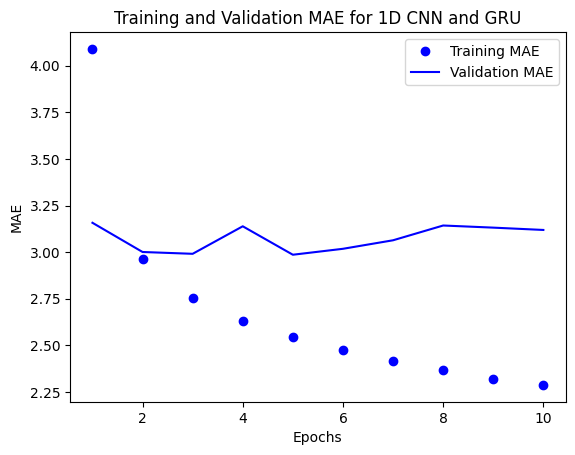

In [100]:
##PLoting results

mae = history.history['mae']
val_mae = history.history['val_mae']
epochs = range(1, len(mae) + 1)

plt.figure()
plt.plot(epochs, mae, 'bo', label='Training MAE')
plt.plot(epochs, val_mae, 'b', label='Validation MAE')
plt.title('Training and Validation MAE for 1D CNN and GRU')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()


In [ ]:
Model 10 - Using bidirectional RNNs - Training and evaluating a bidirectional LSTM

In [101]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

Epoch 1/10
819/819 [==============================] - 62s 71ms/step - loss: 30.5709 - mae: 3.9321 - val_loss: 10.6266 - val_mae: 2.5255
Epoch 2/10
819/819 [==============================] - 57s 70ms/step - loss: 9.5969 - mae: 2.4182 - val_loss: 9.9054 - val_mae: 2.4251
Epoch 3/10
819/819 [==============================] - 58s 70ms/step - loss: 8.7068 - mae: 2.2995 - val_loss: 9.9353 - val_mae: 2.4357
Epoch 4/10
819/819 [==============================] - 57s 70ms/step - loss: 8.1795 - mae: 2.2337 - val_loss: 10.1730 - val_mae: 2.4434
Epoch 5/10
819/819 [==============================] - 57s 70ms/step - loss: 7.8184 - mae: 2.1855 - val_loss: 10.4007 - val_mae: 2.4806
Epoch 6/10
819/819 [==============================] - 57s 69ms/step - loss: 7.5005 - mae: 2.1441 - val_loss: 10.1995 - val_mae: 2.4424
Epoch 7/10
819/819 [==============================] - 57s 70ms/step - loss: 7.2045 - mae: 2.1026 - val_loss: 11.3855 - val_mae: 2.5641
Epoch 8/10
819/819 [==============================] - 57

#Evaluating the Best-Performing Models on the Test Dataset

####First Top-performing model  - Model 8 - Model with Stacked GRU 32,64 (With Dropout)

In [103]:
# Define the stacked GRU model with dropout layers
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(64, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# Define a callback to save the best model during training based on validation MAE
callbacks = [
    keras.callbacks.ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_mae", mode="min", verbose=1)
]

# Compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# Train the model on the training dataset for 10 epochs
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)

# Load the best model based on validation MAE
best_model = keras.models.load_model("best_model.h5")

# Evaluate model8 on the test dataset
test_loss, test_mae = best_model.evaluate(test_dataset)
print("Test Loss:", test_loss)
print("Test MAE:", test_mae)


Epoch 1/10
819/819 [==============================] - ETA: 0s - loss: 24.8084 - mae: 3.6889
Epoch 1: val_mae improved from inf to 2.42686, saving model to best_model.h5
819/819 [==============================] - 159s 187ms/step - loss: 24.8084 - mae: 3.6889 - val_loss: 9.8083 - val_mae: 2.4269
Epoch 2/10
819/819 [==============================] - ETA: 0s - loss: 14.2515 - mae: 2.9221
Epoch 2: val_mae improved from 2.42686 to 2.34979, saving model to best_model.h5
819/819 [==============================] - 152s 186ms/step - loss: 14.2515 - mae: 2.9221 - val_loss: 9.1807 - val_mae: 2.3498
Epoch 3/10
819/819 [==============================] - ETA: 0s - loss: 13.5915 - mae: 2.8534
Epoch 3: val_mae improved from 2.34979 to 2.34137, saving model to best_model.h5
819/819 [==============================] - 152s 186ms/step - loss: 13.5915 - mae: 2.8534 - val_loss: 9.1758 - val_mae: 2.3414
Epoch 4/10
819/819 [==============================] - ETA: 0s - loss: 13.0011 - mae: 2.7917
Epoch 4: val_ma

Second Top-performing model - Model 7 - Model with a GRU(32) Layer (With Dropout)

In [105]:
# Define the model
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# Define a callback to save the best model during training based on validation MAE
callbacks = [
    keras.callbacks.ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_mae", mode="min", verbose=1)
]

# Compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# Train the model
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)

# Load the best model based on validation MAE
best_model = keras.models.load_model("best_model.h5")

# Evaluate model5 on the test dataset
test_loss, test_mae = best_model.evaluate(test_dataset)
print(f"Test MAE: {test_mae:.2f}")

Epoch 1/10
818/819 [============================>.] - ETA: 0s - loss: 42.0912 - mae: 4.6945
Epoch 1: val_mae improved from inf to 2.69994, saving model to best_model.h5
819/819 [==============================] - 54s 63ms/step - loss: 42.0776 - mae: 4.6936 - val_loss: 12.8296 - val_mae: 2.6999
Epoch 2/10
818/819 [============================>.] - ETA: 0s - loss: 10.8373 - mae: 2.5624
Epoch 2: val_mae improved from 2.69994 to 2.42624, saving model to best_model.h5
819/819 [==============================] - 50s 61ms/step - loss: 10.8364 - mae: 2.5623 - val_loss: 9.8783 - val_mae: 2.4262
Epoch 3/10
819/819 [==============================] - ETA: 0s - loss: 9.7723 - mae: 2.4382
Epoch 3: val_mae improved from 2.42624 to 2.40291, saving model to best_model.h5
819/819 [==============================] - 50s 61ms/step - loss: 9.7723 - mae: 2.4382 - val_loss: 9.7509 - val_mae: 2.4029
Epoch 4/10
819/819 [==============================] - ETA: 0s - loss: 9.4614 - mae: 2.3968
Epoch 4: val_mae did no

####Third Top-performing model  - Model 5 - Model with a GRU(16) Layer (No Regularization)

In [108]:

# Define the model
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# Define a callback to save the best model during training based on validation MAE
callbacks = [
    keras.callbacks.ModelCheckpoint("best_model.h7", save_best_only=True, monitor="val_mae", mode="min", verbose=1)
]

# Compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# Train the model
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)

# Load the best model based on validation MAE
best_model = keras.models.load_model("best_model.h7")

# Evaluate the best model on the test dataset
test_loss, test_mae = best_model.evaluate(test_dataset)
print(f"Test MAE: {test_mae:.2f}")



Epoch 1/10
818/819 [============================>.] - ETA: 0s - loss: 41.2468 - mae: 4.6441
Epoch 1: val_mae improved from inf to 2.71187, saving model to best_model.h7


819/819 [==============================] - 56s 66ms/step - loss: 41.2334 - mae: 4.6431 - val_loss: 12.8760 - val_mae: 2.7119
Epoch 2/10
819/819 [==============================] - ETA: 0s - loss: 10.7126 - mae: 2.5507
Epoch 2: val_mae improved from 2.71187 to 2.32933, saving model to best_model.h7


819/819 [==============================] - 52s 64ms/step - loss: 10.7126 - mae: 2.5507 - val_loss: 9.0493 - val_mae: 2.3293
Epoch 3/10
819/819 [==============================] - ETA: 0s - loss: 9.7690 - mae: 2.4418
Epoch 3: val_mae improved from 2.32933 to 2.31933, saving model to best_model.h7


819/819 [==============================] - 53s 65ms/step - loss: 9.7690 - mae: 2.4418 - val_loss: 8.9673 - val_mae: 2.3193
Epoch 4/10
819/819 [==============================] - ETA: 0s - loss: 9.4276 - mae: 2.3994
Epoch 4: val_mae did not improve from 2.31933
819/819 [==============================] - 49s 59ms/step - loss: 9.4276 - mae: 2.3994 - val_loss: 9.2993 - val_mae: 2.3630
Epoch 5/10
819/819 [==============================] - ETA: 0s - loss: 9.1817 - mae: 2.3690
Epoch 5: val_mae did not improve from 2.31933
819/819 [==============================] - 48s 59ms/step - loss: 9.1817 - mae: 2.3690 - val_loss: 9.2966 - val_mae: 2.3543
Epoch 6/10
818/819 [============================>.] - ETA: 0s - loss: 8.9621 - mae: 2.3435
Epoch 6: val_mae did not improve from 2.31933
819/819 [==============================] - 48s 59ms/step - loss: 8.9625 - mae: 2.3435 - val_loss: 9.3910 - val_mae: 2.3644
Epoch 7/10
818/819 [============================>.] - ETA: 0s - loss: 8.7720 - mae: 2.3212
Epoch 